In [1]:
using DrWatson
using GenerativeMIL
using Flux
using Flux3D: chamfer_distance
using MLDataPattern
using ProgressMeter: Progress, next!
using PaddedViews
using PyPlot

In [2]:
function loss_f(m::GenerativeMIL.Models.SetVAE, x::AbstractArray{<:Real}, x_mask::AbstractArray{Bool}, β::Float32=0.01f0)
    #encoder
    x1 = m.encoder.expansion(x) .* x_mask
    x1, h_enc1 = m.encoder.layers[1](x1, x_mask)
    x1, h_enc2 = m.encoder.layers[2](x1, x_mask)
    x1, h_enc3 = m.encoder.layers[3](x1, x_mask)
    x1, h_enc4 = m.encoder.layers[4](x1, x_mask)
    
    #println("encoder", x1)
    _, sample_size, bs = size(x_mask)
    z = m.prior(sample_size, bs)
    #println("sampling", z)
    #decoder
    klds = 0
    x1 = m.decoder.expansion(z) .* x_mask
    x1, kld, _,_ = m.decoder.layers[1](x1, h_enc4, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[2](x1, h_enc3, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[3](x1, h_enc2, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[4](x1, h_enc1, x_mask)
    klds += kld
    x1 = m.decoder.reduction(x1) .* x_mask
    #println("decoder", x1)
    #loss = ChamferDistanceLoss(x, x1) + β * klds
    loss = chamfer_distance(x, x1) + β * klds
    return loss, klds
end

loss_f (generic function with 2 methods)

In [3]:
function transform_batch1(x, max=false)
    a_mask = [ones(size(a)) for a in x];
    if max
        max_set = maximum(size.(x))[end];
    else
        max_set = minimum(size.(x))[end]; #minimum
    end
    b = map(a->Array(PaddedView(0, a, (3, max_set))), x);
    b_mask = map(a->Array(PaddedView(0, a, (3, max_set))), a_mask);
    c = cat(b..., dims=3);
    c_mask = cat(b_mask..., dims=3) .> 0; # mask as BitArray
    c_mask = Array(c_mask[1:1,:,:]);
    return c, c_mask
end

transform_batch1 (generic function with 2 methods)

In [4]:
train, test = GenerativeMIL.Models.load_and_standardize_mnist();

┌ Info: train standardized μ = [14.010735081757533; 13.027597697882937; 174.257433938215;;], σ = [4.270086778902686; 5.572331140597686; 87.89041202121322;;]
└ @ GenerativeMIL.Models F:\AI Center\GenerativeMIL\src\models\utils\dataset.jl:137


In [5]:
dataloader = RandomBatches(train[1], size=32)

RandomBatches(::Vector{Any}, 32, ObsDim.Last())
 Iterator providing Inf batches of size 32

In [6]:
sv = GenerativeMIL.Models.SetVAE(3,64,4,[16,8,4,1], [2,4,8,16], 3, 32);

In [7]:
sv.encoder.layers|>size

(4,)

In [8]:
#loss, back = Flux.pullback(ps) do 
#    loss_f(sv, x, x_mask, 0f0) 
#end;

In [9]:
#grad = back(1f0);
#Flux.Optimise.update!(opt, ps, grad);

In [10]:
sv = GenerativeMIL.Models.SetVAE(3,64,4,[16,8,4,1], [2,4,8,16], 3, 32);
sv_tmp = deepcopy(sv);
ps = Flux.params(sv);
opt = ADAM()
losses = []
iters = 1000
sizes = []
progress = Progress(iters)
beta = 0.01f0
for (i, batch) in enumerate(dataloader)
    x, x_mask = transform_batch1(batch,true)#GenerativeMIL.Models.transform_batch(batch)
    x = Float32.(x)
    push!(sizes, size(x,2))
    #println(x|>size, x_mask|>size)
    loss, back = Flux.pullback(ps) do 
        loss_f(sv, x, x_mask, beta) 
    end;
    grad = back((1f0,0f0));
    Flux.Optimise.update!(opt, ps, grad);
    #@info "loss = $(loss)"
    push!(losses, loss)
    next!(progress; showvalues=[(:iters, "$(i)/$(iters)"),(:loss, loss[1]),(:klds, loss[2])])
    if i == 10000
        beta = 0.01f0
    elseif i ==iters
        break
    end
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\ghost_000\.julia\packages\ProgressMeter\sN2xr\src\ProgressMeter.jl:618
Progress: 100%|█████████████████████████████████████████| Time: 0:09:25
  iters:  1000/1000
  loss:   0.22826367503153933
  klds:   0.24454880878329277


In [11]:
print(Flux.mean(Flux.params(sv_tmp.encoder).==Flux.params(sv.encoder)), "|")
print(Flux.mean(Flux.params(sv_tmp.decoder).==Flux.params(sv.decoder)), "|")
print(Flux.mean(Flux.params(sv_tmp.prior).==Flux.params(sv.prior)))

0.02631578947368421|0.011363636363636364|0.0

In [12]:
print(Flux.sum(Flux.params(sv_tmp.encoder).==Flux.params(sv.encoder)), "|")
print(Flux.sum(Flux.params(sv_tmp.decoder).==Flux.params(sv.decoder)), "|")
print(Flux.sum(Flux.params(sv_tmp.prior).==Flux.params(sv.prior)))

2|2|0

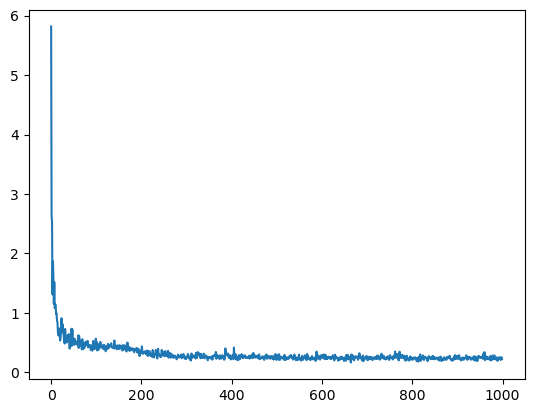

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000706BEEE0>

In [13]:
plot(map(x->x[1], losses))#plot(losses)

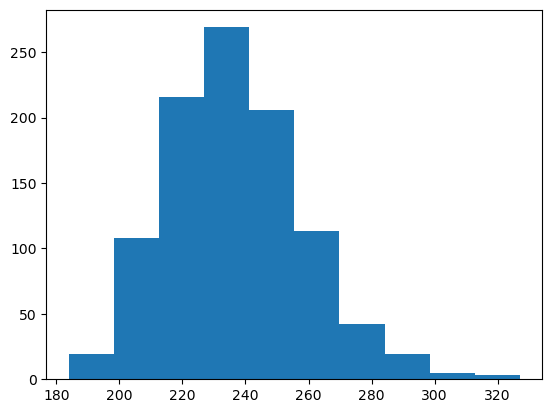

In [14]:
hist(sizes);

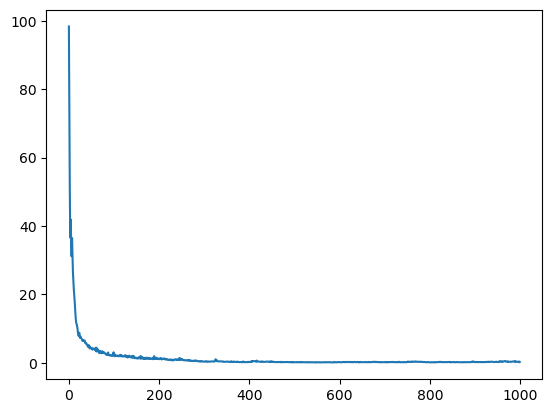

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000007016B8E0>

In [15]:
plot(map(x->x[2], losses))

In [14]:
dafasfasfasf

LoadError: UndefVarError: dafasfasfasf not defined

In [26]:
xx = 0
xx_mask = 0
for test in dataloader
    xx, xx_mask = transform_batch1(test, true)
    xx = Float32.(xx)
    break
end

In [27]:
function forw(m::GenerativeMIL.Models.SetVAE, x::AbstractArray{<:Real}, x_mask::AbstractArray{Bool}, β::Float32=0.01f0)
    #encoder
    x1 = m.encoder.expansion(x) .* x_mask
    x1, h_enc1 = m.encoder.layers[1](x1, x_mask)
    x1, h_enc2 = m.encoder.layers[2](x1, x_mask)
    x1, h_enc3 = m.encoder.layers[3](x1, x_mask)
    x1, h_enc4 = m.encoder.layers[4](x1, x_mask)
    
    _, sample_size, bs = size(x_mask)
    z = m.prior(sample_size, bs)
    
    #decoder
    klds = 0
    x1 = m.decoder.expansion(z) .* x_mask
    x1, kld, _,_ = m.decoder.layers[1](x1, h_enc4, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[2](x1, h_enc3, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[3](x1, h_enc2, x_mask)
    klds += kld
    x1, kld, _,_ = m.decoder.layers[4](x1, h_enc1, x_mask)
    klds += kld
    x1 = m.decoder.reduction(x1) .* x_mask
    #loss = ChamferDistanceLoss(x, x1) + β * klds
    return x1
end

forw (generic function with 2 methods)

In [48]:
y = forw(sv, xx, xx_mask);

In [62]:
yy = y[:,:,8];

In [63]:
yy |> size

(3, 216)

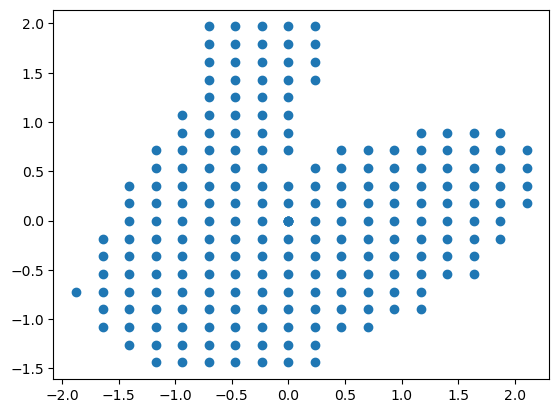

PyObject <matplotlib.collections.PathCollection object at 0x00000000D6406430>

In [74]:
scatter(xx[1,:,30], xx[2,:,30])

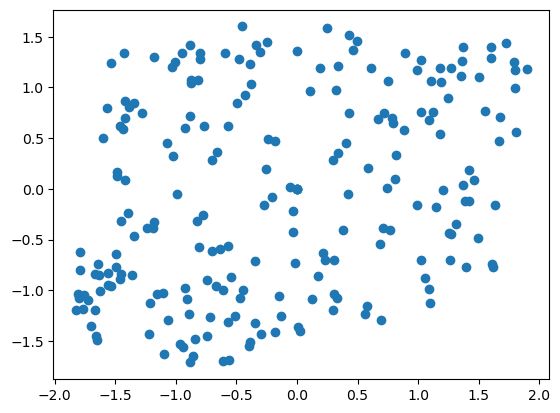

PyObject <matplotlib.collections.PathCollection object at 0x00000000D646FCA0>

In [75]:
scatter(y[1,:,30], y[2,:,30])

In [19]:
#y[:,:,end]

In [20]:
losses

200-element Vector{Any}:
 4.9109138616633174
 3.2231548254766906
 1.5511453734192742
 1.376289877252941
 1.5160141422933915
 1.3249798332140157
 1.1204528914874787
 1.1780680757885462
 0.9800440250442674
 0.7402565359794262
 1.0840892548637346
 0.8100583980445959
 0.7466132603850199
 ⋮
 0.5107088557775473
 0.4827751492086853
 0.44803662019413815
 0.4465033793746775
 0.5041566591931825
 0.6160068135008958
 0.49828455121592563
 0.491665753943473
 0.4906397582968852
 0.5248843718569464
 0.5801990929663784
 0.45816561409466555

In [21]:
using DelimitedFiles
outdata = Dict(:data => losses)
#save("losses1.bson", outdata)

Dict{Symbol, Vector{Any}} with 1 entry:
  :data => [4.91091, 3.22315, 1.55115, 1.37629, 1.51601, 1.32498, 1.12045, 1.17…

In [100]:
sv.encoder.layers

4-element Vector{Any}:
 GenerativeMIL.Models.InducedSetAttentionBlock(MultiheadAttentionBlock( 
 - Mulithead = MultiheadAttention(
 - heads = 4 
 - WQ = Dense(64, 64; bias=false) 
 - WK = Dense(64, 64; bias=false)
 - WV = Dense(64, 64; bias=false) 
 - WO = Dense(64, 64; bias=false) 
 - attention = slot_attention 
 )  
 - FF = Dense(64, 64) 
 - LN1 = LayerNorm((64, 1)) 
 - LN2 = LayerNorm((64, 1)) 
 ) , MultiheadAttentionBlock( 
 - Mulithead = MultiheadAttention(
 - heads = 4 
 - WQ = Dense(64, 64; bias=false) 
 - WK = Dense(64, 64; bias=false)
 - WV = Dense(64, 64; bias=false) 
 - WO = Dense(64, 64; bias=false) 
 - attention = slot_attention 
 )  
 - FF = Dense(64, 64) 
 - LN1 = LayerNorm((64, 1)) 
 - LN2 = LayerNorm((64, 1)) 
 ) , Float32[1.2486424 -0.9406918 … -0.9540901 -0.92040163; 1.0494735 -0.592735 … 1.304619 -0.9012023; … ; -0.12554891 -0.6930172 … -0.6420724 -0.98083204; -0.2573568 -1.1702851 … 1.4623628 -0.2292235])
 GenerativeMIL.Models.InducedSetAttentionBlock(MultiheadAtte